Randomモジュールをインポート

In [406]:
import random

import numpy as np
import matplotlib.pyplot as plt

In [407]:
x = np.linspace(-10, 10, 100)

### ネイピア数
$$e = (1+1/1000000000)^{1000000000}$$

In [408]:
def napiers_logarithm(x):
    return (1 + 1 / x) ** x
napier_number = napiers_logarithm(1000000000)  # e

### シグモイド関数
$$Sigmoid(x)=\frac{1}{1+Napiers(1000000000)^{-x}}$$

In [409]:
def sigmoid(x):
    return 1 / (1 + napier_number ** -x)

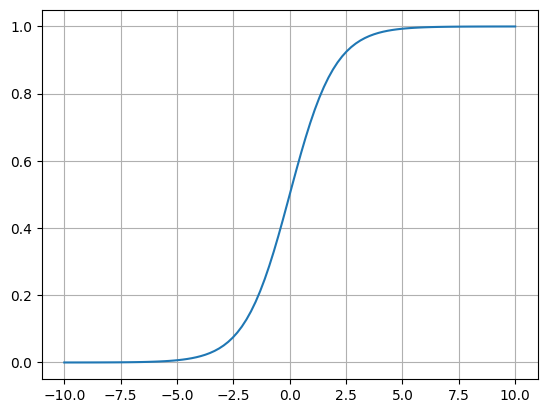

In [410]:
y = sigmoid(x)

plt.plot(x, y)
plt.grid(True)
plt.show()

### シグモイド関数の微分
$$Sigmoid'(x)=Sigmoid(x)(1 - Sigmoid(x))$$

In [411]:
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

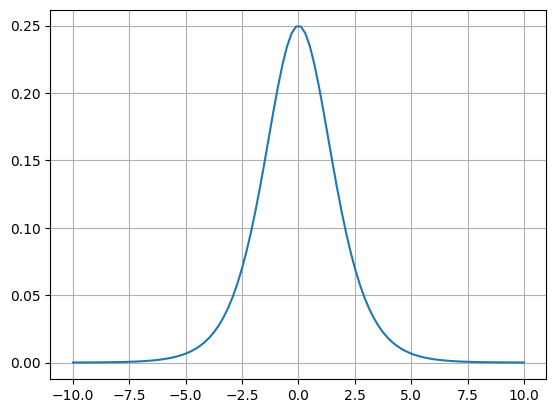

In [412]:
y = sigmoid_derivative(x)

plt.plot(x, y)
plt.grid(True)
plt.show()

### ReLU関数
$$ReLU(x) =
        \begin{cases}
            x \quad x \geqq 0 \\
            0 \quad x < 0 \\
        \end{cases}
$$

In [413]:
def relu(x):
    return max(0, x)

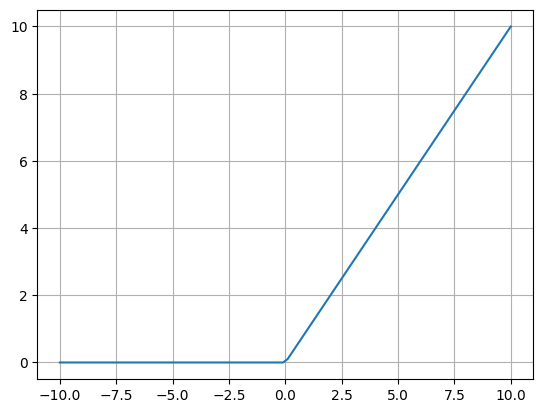

In [414]:
y = [relu(xi) for xi in x]

plt.plot(x, y)
plt.grid(True)
plt.show()

### ReLU関数の微分
$$ReLU'(x) =
        \begin{cases}
            1 \quad x > 0 \\
            0 \quad x \leqq 0 \\
        \end{cases}
$$

In [415]:
def relu_derivative(x):
    return 1 if x > 0 else 0

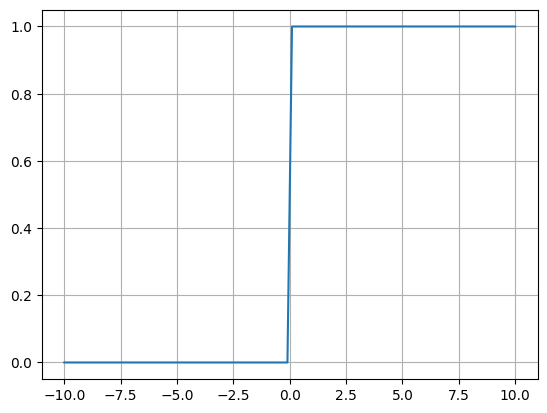

In [416]:
y = [relu_derivative(xi) for xi in x]

plt.plot(x, y)
plt.grid(True)
plt.show()

### 自然対数
$$ln(x) = 2 \sum_{n=1,3,5,\dots}^{\infty} \frac{(z^n)}{n}, \quad z = \frac{x-1}{x+1}$$

In [417]:
def ln(x, n_terms=100):
    if x <= 0: raise ValueError("x must be positive")
    return (x - 1) / (x + 1) * sum([((x - 1) / (x + 1) ** n) / n for n in range(1, n_terms + 1, 2)])

### クロスエントロピー損失
$$L(y_{\text{true}}, y_{\text{pred}}) = - \sum_{i=1}^{n} y_{\text{true}_i} \cdot \ln(y_{\text{pred}_i} + \epsilon)$$

In [418]:
def cross_entropy_loss(y_true, y_pred):
    if len(y_true) != len(y_pred): raise ValueError("Input lists must have the same length.")
    return -sum([t * ln(p + 1e-9) for t, p in zip(y_true, y_pred)])

### ニューラルネットワークを初期化
例:&emsp;入力層 -> 2,&emsp;隠れ層 -> [3, 3],&emsp;出力層 -> 1
#### 重み
$$n_{n}={2, 3, 3, 1}$$
$$ random \in [-1, 1] $$
$$[[[random]*n_{1}]*n_{2}, [[random]*n_{2}]*n_{3}, [[random]*n_{3}]*n_{4}]$$
#### バイアス
$$n_{n}={3, 3, 1}$$
$$ random \in [-1, 1] $$
$$[[random]*n_{1},[random]*n_{2},[random]*n_{3}]$$

※ [n]*5 -> [n, n, n, n, n]

In [419]:
def initialize_weights(layer_sizes):  # initialize weights and biases
    weights, biases = [], []
    for i in range(len(layer_sizes) - 1):
        weights.append([[random.uniform(-1, 1) for _ in range(layer_sizes[i])] for _ in range(layer_sizes[i+1])])  # [ {random_num *layer_sizes[i]} *layer_sizes[i+1] ]
        biases.append([random.uniform(-1, 1) for _ in range(layer_sizes[i+1])])  # [ random_num *layer_sizes[i+1] ]
    return weights, biases

### 順伝播処理

In [420]:
def forward_propagation(inputs, weights, biases):  # forward propagation
    activations = [inputs]
    for W, b in zip(weights, biases):
        activations.append([
            relu(sum([activations[-1][i] * W[j][i] for i in range(len(activations[-1]))]) + b[j])
            for j in range(len(b))
        ])
    return activations

### 逆伝播処理

In [421]:
def backward_propagation(activations, y_true, weights, biases, learning_rate):  # backward propagation
    output_layer = activations[-1]
    deltas = [[
        (output_layer[i] - y_true[i]) * sigmoid_derivative(output_layer[i])
        for i in range(len(y_true))
    ]]
    # Backpropagating the hidden layer error
    for l in range(len(weights)-1, 0, -1):
        deltas.insert(0, [
            sum([deltas[0][k] * weights[l][k][j] for k in range(len(deltas[0]))]) * relu_derivative(activations[l][j])
            for j in range(len(activations[l]))
        ])
    # Update the weights and biases
    for l in range(len(weights)):
        for i in range(len(weights[l])):
            for j in range(len(weights[l][i])):
                weights[l][i][j] -= learning_rate * deltas[l][i] * activations[l][j]
            biases[l][i] -= learning_rate * deltas[l][i]

    return weights, biases

### ニューラルネットワークを学習

In [422]:
def train(X, y, layer_sizes, epochs, learning_rate):
    weights, biases = initialize_weights(layer_sizes)
    weights_list = []
    for epoch in range(epochs):
        total_loss = 0
        for i in range(len(X)):
            activations = forward_propagation(X[i], weights, biases)
            total_loss += cross_entropy_loss(y[i], activations[-1])
            weights, biases = backward_propagation(activations, y[i], weights, biases, learning_rate)
            weights_list.append(weights)
        
        m = (epoch + (epochs // 20) - 1) // (epochs // 20)
        print(f"\rEpoch {epoch+1}/{epochs}, Loss: {total_loss/len(X)}, [{'+'*m}{' '*(20-m)}]{' '*10}",end="")
    print("\nComplete")
    return weights, biases, weights_list

### パラメーターの設定および関数呼び出し

In [439]:
# DataSet for XOR
X = [[0, 0], [0, 1], [1, 0], [1, 1]]  # Input
y = [[0], [1], [1], [0]]  # Output

epochs = 200  # Number of epochs
learning_rate = 0.1  # Learning rate
layer_sizes = [2, 16, 1]  # 2 input -> 16 hidden -> 1 output

weights, biases, weights_list = train(X, y, layer_sizes, epochs, learning_rate)

for i in range(len(X)):  # Prediction
    activations = forward_propagation(X[i], weights, biases)
    output = activations[-1]
    binary_output = [1 if o >= 0.5 else 0 for o in output]
    print(f"Inputs: {X[i]}, Output: {y[i]} Predict: {binary_output}, probability: {round(output[0], 3)}")

Epoch 200/200, Loss: -2.103172911595253e-09, [++++++++++++++++++++]           
Complete
Inputs: [0, 0], Output: [0] Predict: [0], probability: 0.0
Inputs: [0, 1], Output: [1] Predict: [1], probability: 1.0
Inputs: [1, 0], Output: [1] Predict: [1], probability: 1.0
Inputs: [1, 1], Output: [0] Predict: [0], probability: 0.0
